## Inits

In [1]:
!pip install pykan

In [2]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

device = torch.device("cuda")
print(device)

cuda


## Dataset

In [3]:
def load_iris_dataset():
    # Load California housing dataset
    iris = load_iris()
    data = iris.data
    target = iris.target

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.long)

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.2, random_state=42)

    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=1, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=1, shuffle=False)

    train_inputs = torch.empty(0, 4, device=device)
    train_labels = torch.empty(0, dtype=torch.long, device=device)
    test_inputs = torch.empty(0, 4, device=device)
    test_labels = torch.empty(0, dtype=torch.long, device=device)

    # Concatenate all data into a single tensor on the specified device
    for data, labels in train_loader:
        train_inputs = torch.cat((train_inputs, data.to(device)), dim=0)
        train_labels = torch.cat((train_labels, labels.to(device)), dim=0)

    for data, labels in test_loader:
        test_inputs = torch.cat((test_inputs, data.to(device)), dim=0)
        test_labels = torch.cat((test_labels, labels.to(device)), dim=0)

    dataset = {}
    dataset['train_input'] = train_inputs
    dataset['test_input'] = test_inputs
    dataset['train_label'] = train_labels
    dataset['test_label'] = test_labels

    return dataset

iris_dataset = load_iris_dataset()

In [4]:
print("Train data shape: {}".format(iris_dataset['train_input'].shape))
print("Train target shape: {}".format(iris_dataset['train_label'].shape))
print("Test data shape: {}".format(iris_dataset['test_input'].shape))
print("Test target shape: {}".format(iris_dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([120, 4])
Train target shape: torch.Size([120])
Test data shape: torch.Size([30, 4])
Test target shape: torch.Size([30])


In [5]:
def print_example_data_point(dataset):
    # Get column names from the dataset
    column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

    # Get a single data point from the dataset
    example_data_point = dataset['train_input'][0]

    # Get the corresponding target for the example data point
    example_target = int(dataset['train_label'][0])

    # Map numerical target to actual string label
    target_names = ['setosa', 'versicolor', 'virginica']
    actual_label = target_names[example_target]

    # Print column names and their corresponding values
    for i, column_name in enumerate(column_names):
        print(f"{column_name}: {example_data_point[i]}")

    # Print the target value and the actual string label
    print(f"Target (numerical): {example_target}")
    print(f"Actual Label: {actual_label}")

print_example_data_point(iris_dataset)

sepal_length: 6.199999809265137
sepal_width: 3.4000000953674316
petal_length: 5.400000095367432
petal_width: 2.299999952316284
Target (numerical): 2
Actual Label: virginica


## Model

In [11]:
image_folder = 'video_img'

In [12]:
model = KAN(width=[4, 5, 3], grid=5, k=3, seed=0, device=device)

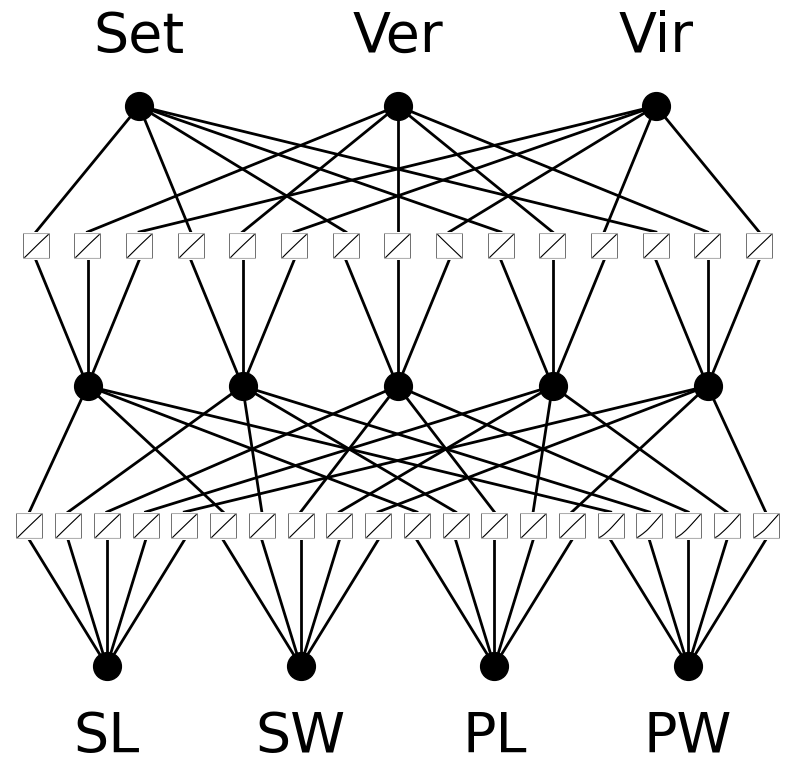

In [13]:
model(iris_dataset['train_input'])
model.plot(beta=100, scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['Set', 'Ver', 'Vir'])

In [14]:
def train_acc():
    return torch.mean((torch.argmax(model(iris_dataset['train_input']), dim=1) == iris_dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(iris_dataset['test_input']), dim=1) == iris_dataset['test_label']).float())

results = model.train(iris_dataset, opt="Adam", device=device, metrics=(train_acc, test_acc),
                      loss_fn=torch.nn.CrossEntropyLoss(), steps=100, lamb=0.01, lamb_entropy=10., save_fig=True, img_folder=image_folder)
results['train_acc'][-1], results['test_acc'][-1]

train loss: 1.07e-02 | test loss: 8.49e-01 | reg: 1.89e+02 : 100%|█| 100/100 [08:18<00:00,  4.99s/it


(0.9916667342185974, 0.9666666984558105)

In [15]:
import moviepy.video.io.ImageSequenceClip

video_name='video'
fps=10

fps = fps
files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

Moviepy - Building video video.mp4.
Moviepy - Writing video video.mp4



Moviepy - Done !
Moviepy - video ready video.mp4


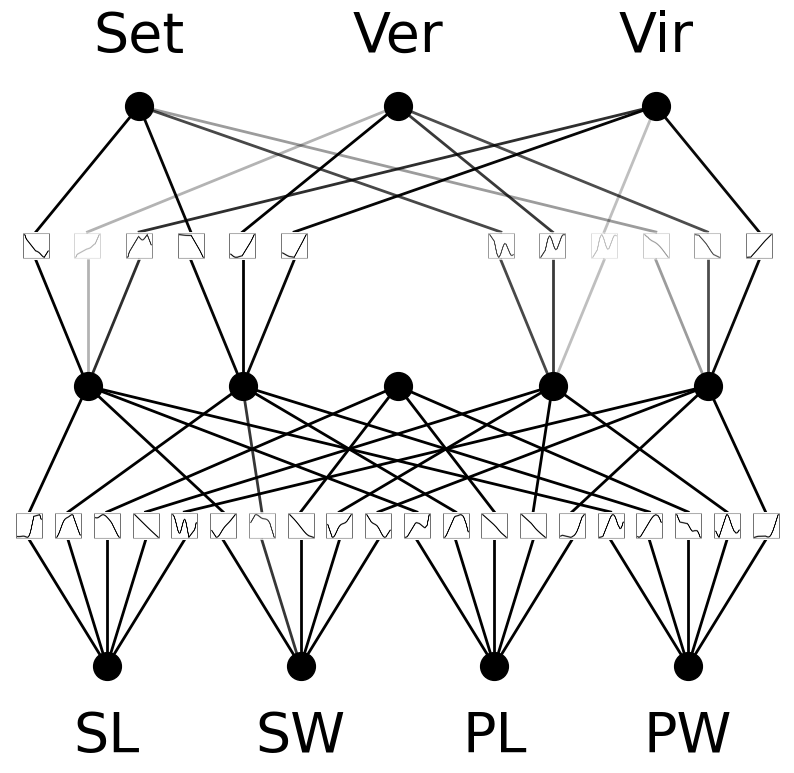

In [16]:
model.plot(scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['Set', 'Ver', 'Vir'])

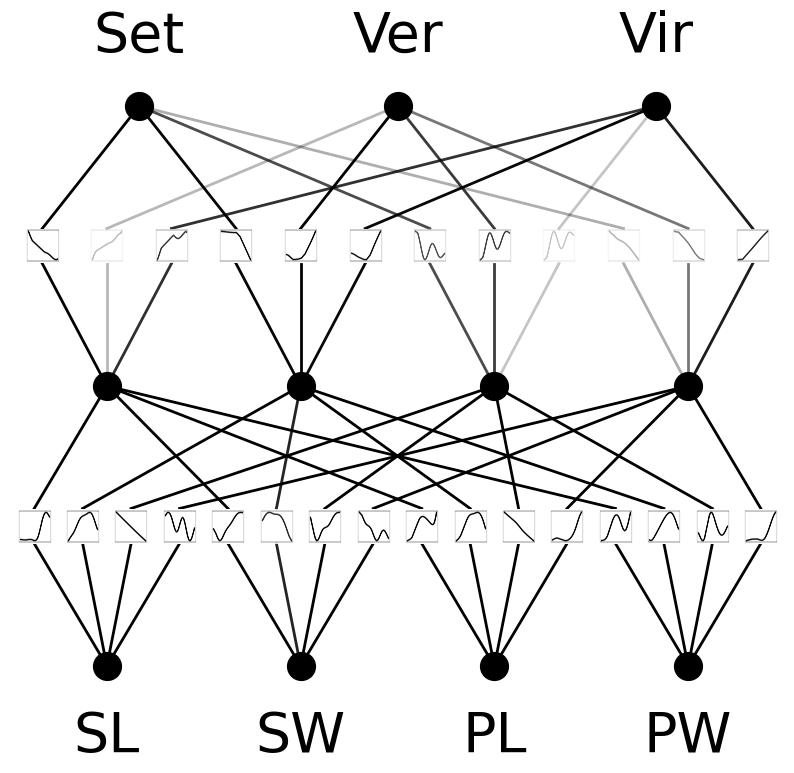

In [17]:
model = model.prune()
model(iris_dataset['train_input'])
model.plot(scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['Set', 'Ver', 'Vir'])

In [ ]:
# fine tune
results_1 = model.train(iris_dataset, opt="Adam", device=device, metrics=(train_acc, test_acc),
                      loss_fn=torch.nn.CrossEntropyLoss(), steps=50, lamb=0.01, lamb_entropy=10.)
results_1['train_acc'][-1], results_1['test_acc'][-1]

In [ ]:
model.plot(scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['Set', 'Ver', 'Vir'])

In [ ]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)

# Neural Net

In [ ]:
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 5)  # 4 inputs to 5 hidden nodes
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(5, 3)  # 5 hidden nodes to 3 outputs

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')

In [ ]:
def load_iris_dataset():
    # Load California housing dataset
    iris = load_iris()
    data = iris.data
    target = iris.target

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.long)

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.2, random_state=42)

    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=10, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=10, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = load_iris_dataset()

In [ ]:
model = IrisNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_model(model, train_loader, criterion, optimizer)
test_model(model, test_loader)